# Introduction
Different steps to build a machine learning (ML) model for equitable clinical care associated with a ***continous*** protected attribute. In this notebook, we will see how to:
1. Auditing algorithmic bias for a trained model
2. Dressing algorithmic bias by applying different bias mitigation strategies

Specifically, we build an ML model for depression using the NHANES dataset (https://wwwn.cdc.gov/nchs/nhanes/default.aspx). Here, we examine the behavior of the learned ML model with respect to protected attribute ***age***

# Install library

In [ ]:
!pip install aif360==0.3.0
!pip install BlackBoxAuditing==0.1.54

## 1. Auditing algorithmic bias

In [ ]:
from google.colab import drive
import os
import copy
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/PhD/code_npj')
os.getcwd()
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=UserWarning)
import pandas as pd
import numpy as np
from pandas import read_csv
from FairML.utils import dataset
from FairML.algorithms.benchmark import benchmark
#from FairML.utils.dataset import model_preparation_nhanes, nhanes_lr
from joblib import dump, load
from sklearn.model_selection import StratifiedKFold

# Defining x and y
full_df = pd.read_csv('Datasets/FullData_rm_dl_bt.csv', index_col='SEQN')
x = full_df.drop('depression', axis=1)
y = full_df['depression'].map({'Not Depressed': 0, 'Depressed': 1})

FOLDS = 10
k_fold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
cls_mdls = {}
bins= [0,20,40,60,80,86]
labels = ['0–20 years','20–40 years','40–60 years','60–80 years','>80 years']
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train1, X_test1 = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train1, X_test1)
  X_train['AgeGroup'] = pd.cut(X_train1['age'], bins=bins, labels=labels, right=False)
  X_test['AgeGroup'] = pd.cut(X_test1['age'], bins=bins, labels=labels, right=False)
  X_train.loc[X_train1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_train.loc[X_train1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_train.loc[X_train1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_test.loc[X_test1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_test.loc[X_test1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_test.loc[X_test1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_train['AgeGroup'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_test['AgeGroup'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  model_path = 'Models/nhanes/lr/model_{}.joblib'.format(i) 
  unprivileged_groups=[{'AgeGroup': 0}]
  privileged_groups=[{'AgeGroup': 2}]
  conditions = [[{'AgeGroup':0}],[{'AgeGroup':1}],[{'AgeGroup':2}],[{'AgeGroup':3}],[{'AgeGroup':4}]]
  label_name,protected_attribute_name = 'depression', 'AgeGroup'
  protected_attribute_values = ['0-20','20-40','40-60','60-80','80+']
  sup = ['AgeGroup']
  cls_mdls = benchmark.benchmark(X_train,y_train,X_test,y_test,cls_mdls,model_path,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,sup)
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_base_nhanes_age.csv', index=True)

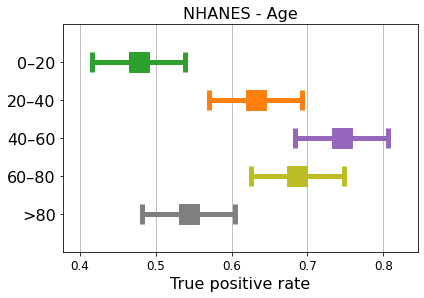

In [ ]:
from FairML.utils import plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
lr_base_nh = read_csv('Results/dataframe/lr_base_nhanes_age.csv')
Group_age = ['0–20']*10 + ['20–40']*10 + ['40–60']*10+ ['60–80']*10  + ['>80']*10 
Value_class_rate = pd.concat([lr_base_nh['tpr_0-20'],lr_base_nh['tpr_20-40'],\
                              lr_base_nh['tpr_40-60'],lr_base_nh['tpr_60-80'],\
                              lr_base_nh['tpr_80+']], axis = 0).to_numpy()
acc_age = {"Rate":Value_class_rate,"Group_age": Group_age} 
acc_age = pd.DataFrame(acc_age)                                
tukey = pairwise_tukeyhsd(groups=acc_age['Group_age'], endog=acc_age['Rate'].values)
plot.plot_sim2(tukey,xlabel='True positive rate')
plt.tight_layout()
plt.title("NHANES - Age",fontsize=16)
plt.savefig('Results/img/lrnhanes-age-tukey-base.png', dpi=1200,bbox_inches='tight')

# 2. Addressing algorithmic bias 

## 2.1 SUP

In [ ]:
from FairML.algorithms.preprocessing import sup
cls_mdls = {}
bins= [0,20,40,60,80,86]
labels = ['0–20 years','20–40 years','40–60 years','60–80 years','>80 years']
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train1, X_test1 = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train1, X_test1)
  X_train['AgeGroup'] = pd.cut(X_train1['age'], bins=bins, labels=labels, right=False)
  X_test['AgeGroup'] = pd.cut(X_test1['age'], bins=bins, labels=labels, right=False)
  X_train.loc[X_train1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_train.loc[X_train1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_train.loc[X_train1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_test.loc[X_test1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_test.loc[X_test1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_test.loc[X_test1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_train['AgeGroup1'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_test['AgeGroup1'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_train['AgeGroup'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  X_test['AgeGroup'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  unprivileged_groups=[{'AgeGroup': 0}]
  privileged_groups=[{'AgeGroup': 2}]
  conditions = [[{'AgeGroup1':0}],[{'AgeGroup1':1}],[{'AgeGroup1':2}],[{'AgeGroup1':3}],[{'AgeGroup1':4}]]
  label_name,protected_attribute_name = 'depression', 'AgeGroup'
  protected_attribute_values = ['0-20','20-40','40-60','60-80','80+']
  sup1 = ['AgeGroup','age','AgeGroup1']
  model_arch = 'nh-lr'
  cls_mdls = sup.sup(X_train,y_train,X_test,y_test,cls_mdls,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,model_arch,sup1)
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_sup_nhanes_age.csv', index=True)

## 2.2 RW

In [ ]:
from FairML.algorithms.preprocessing import rw
cls_mdls = {}
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train1, X_test1 = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train1, X_test1)
  X_train['AgeGroup'] = pd.cut(X_train1['age'], bins=bins, labels=labels, right=False)
  X_test['AgeGroup'] = pd.cut(X_test1['age'], bins=bins, labels=labels, right=False)
  X_train.loc[X_train1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_train.loc[X_train1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_train.loc[X_train1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_test.loc[X_test1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_test.loc[X_test1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_test.loc[X_test1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_train['AgeGroup1'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_test['AgeGroup1'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_train['AgeGroup'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  X_test['AgeGroup'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  unprivileged_groups=[{'AgeGroup': 0}]
  privileged_groups=[{'AgeGroup': 2}]
  conditions = [[{'AgeGroup1':0}],[{'AgeGroup1':1}],[{'AgeGroup1':2}],[{'AgeGroup1':3}],[{'AgeGroup1':4}]]
  label_name,protected_attribute_name = 'depression', 'AgeGroup'
  protected_attribute_values = ['0-20','20-40','40-60','60-80','80+']
  sup1 = ['AgeGroup','AgeGroup1']
  model_arch = 'nh-lr'
  cls_mdls = rw.rw(X_train,y_train,X_test,y_test,cls_mdls,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,model_arch,sup1)
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_rw_nhanes_age.csv', index=True)

## 2.3 DIR

In [ ]:
from FairML.algorithms.preprocessing import dir
cls_mdls = {}
bins= [0,20,40,60,80,86]
labels = ['0–20 years','20–40 years','40–60 years','60–80 years','>80 years']
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train1, X_test1 = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train1, X_test1)
  X_train['AgeGroup'] = pd.cut(X_train1['age'], bins=bins, labels=labels, right=False)
  X_test['AgeGroup'] = pd.cut(X_test1['age'], bins=bins, labels=labels, right=False)
  X_train.loc[X_train1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_train.loc[X_train1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_train.loc[X_train1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_test.loc[X_test1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_test.loc[X_test1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_test.loc[X_test1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_train['AgeGroup1'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_test['AgeGroup1'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_train['AgeGroup'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  X_test['AgeGroup'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  unprivileged_groups=[{'AgeGroup': 0}]
  privileged_groups=[{'AgeGroup': 2}]
  conditions = [[{'AgeGroup1':0}],[{'AgeGroup1':1}],[{'AgeGroup1':2}],[{'AgeGroup1':3}],[{'AgeGroup1':4}]]
  label_name,protected_attribute_name = 'depression', 'AgeGroup'
  protected_attribute_values = ['0-20','20-40','40-60','60-80','80+']
  model_arch = 'nh-lr'
  sup = ['AgeGroup','age','AgeGroup1']
  cls_mdls = dir.dir_(X_train,y_train,X_test,y_test,cls_mdls,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,model_arch,sup)
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_dir_nhanes_age.csv', index=True)

# 2.4 CPP

In [ ]:
from FairML.algorithms.postprocessing import cpp
cls_mdls = {}
cls_cpp = {}
bins= [0,20,40,60,80,86]
labels = ['0–20 years','20–40 years','40–60 years','60–80 years','>80 years']
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train1, X_test1 = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train1, X_test1)
  X_train['AgeGroup'] = pd.cut(X_train1['age'], bins=bins, labels=labels, right=False)
  X_test['AgeGroup'] = pd.cut(X_test1['age'], bins=bins, labels=labels, right=False)
  X_train.loc[X_train1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_train.loc[X_train1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_train.loc[X_train1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_test.loc[X_test1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_test.loc[X_test1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_test.loc[X_test1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_train['AgeGroup1'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_test['AgeGroup1'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_train['AgeGroup'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  X_test['AgeGroup'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  model_path = 'Models/nhanes/lr/model_{}.joblib'.format(i) 
  unprivileged_groups=[{'AgeGroup': 0}]
  privileged_groups=[{'AgeGroup': 2}]
  conditions = [[{'AgeGroup1':0}],[{'AgeGroup1':1}],[{'AgeGroup1':2}],[{'AgeGroup1':3}],[{'AgeGroup1':4}]]
  label_name,protected_attribute_name = 'depression', 'AgeGroup'
  protected_attribute_values = ['0-20','20-40','40-60','60-80','80+']
  sup = ['AgeGroup','AgeGroup1']
  cls_mdls, cls_cpp = cpp.cpp(X_train,y_train,X_test,y_test,cls_mdls,cls_cpp,model_path,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,sup)
cls_metrics_df = pd.DataFrame.from_dict(cls_cpp, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_cpp_nhanes_age.csv', index=True)

## 2.5 PSTA

In [ ]:
from FairML.algorithms.postprocessing import st
cls_mdls = {}
cls_3st = {}
bins= [0,20,40,60,80,86]
labels = ['0–20 years','20–40 years','40–60 years','60–80 years','>80 years']
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train1, X_test1 = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train1, X_test1)
  X_train['AgeGroup'] = pd.cut(X_train1['age'], bins=bins, labels=labels, right=False)
  X_test['AgeGroup'] = pd.cut(X_test1['age'], bins=bins, labels=labels, right=False)
  X_train.loc[X_train1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_train.loc[X_train1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_train.loc[X_train1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_test.loc[X_test1['age'] ==20, 'AgeGroup'] = '0–20 years'
  X_test.loc[X_test1['age'] ==40, 'AgeGroup'] = '20–40 years'
  X_test.loc[X_test1['age'] ==60, 'AgeGroup'] = '40–60 years'
  X_train['AgeGroup1'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_test['AgeGroup1'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':4})
  X_train['AgeGroup'] = X_train['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  X_test['AgeGroup'] = X_test['AgeGroup'].map({'0–20 years':0,'20–40 years':1,'40–60 years':2,'60–80 years':3,'>80 years':0})
  model_path = 'Models/nhanes/lr/model_{}.joblib'.format(i) 
  unprivileged_groups=[{'AgeGroup': 0}]
  privileged_groups=[{'AgeGroup': 2}]
  conditions = [[{'AgeGroup1':0}],[{'AgeGroup1':1}],[{'AgeGroup1':2}],[{'AgeGroup1':3}],[{'AgeGroup1':4}]]
  label_name,protected_attribute_name = 'depression', 'AgeGroup'
  protected_attribute_values = ['0-20','20-40','40-60','60-80','80+']
  unprivileged_value_3st=['AgeGroup1',0,4]
  sup = ['AgeGroup','AgeGroup1']
  cls_mdls, cls_3st = st.st(X_train,y_train,X_test,y_test,cls_mdls,cls_3st,model_path,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,\
              unprivileged_value_3st,sup)
cls_metrics_df = pd.DataFrame.from_dict(cls_3st, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_3st_nhanes_age.csv', index=True)

## 2.6 Plot figures

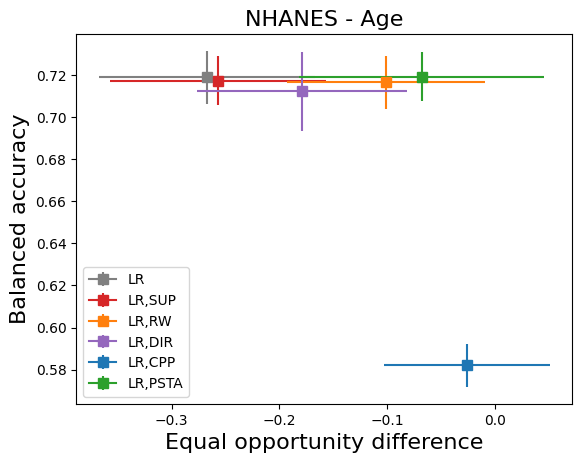

In [5]:
orig = read_csv('Results/dataframe/lr_base_nhanes_age.csv')[['bacc_test','EOD']]
sup = read_csv('Results/dataframe/lr_sup_nhanes_age.csv')[['bacc_test','EOD']]
rw = read_csv('Results/dataframe/lr_rw_nhanes_age.csv')[['bacc_test','EOD']]
dir = read_csv('Results/dataframe/lr_dir_nhanes_age.csv')[['bacc_test','EOD']]
cpp = read_csv('Results/dataframe/lr_cpp_nhanes_age.csv')[['bacc_test','EOD']]
st = read_csv('Results/dataframe/lr_3st_nhanes_age.csv')[['bacc_test','EOD']]
plot.plot_tradeoff(orig,sup,rw,dir,cpp,st,'NHANES - Age','Results/img/lrnh-age-tradeoff-size16.png')
plt.legend(['LR','LR,SUP',\
            'LR,RW','LR,DIR','LR,CPP','LR,PSTA'],
           loc='lower left',fancybox=True)

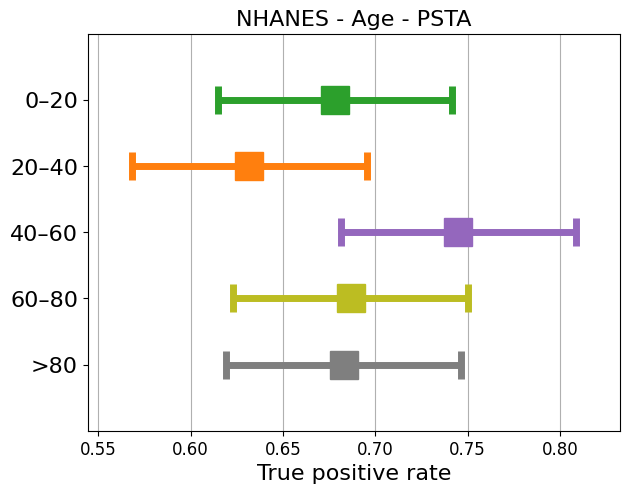

In [6]:
lr_base_nh = read_csv('Results/dataframe/lr_3st_nhanes_age.csv')
Group_age = ['0–20']*10 + ['20–40']*10 + ['40–60']*10+ ['60–80']*10  + ['>80']*10 
Value_class_rate = pd.concat([lr_base_nh['tpr_0-20'],lr_base_nh['tpr_20-40'],\
                              lr_base_nh['tpr_40-60'],lr_base_nh['tpr_60-80'],\
                              lr_base_nh['tpr_80+']], axis = 0).to_numpy()
acc_age = {"Rate":Value_class_rate,"Group_age": Group_age} 
acc_age = pd.DataFrame(acc_age)                                
tukey = pairwise_tukeyhsd(groups=acc_age['Group_age'], endog=acc_age['Rate'].values)
plot.plot_sim2(tukey,xlabel='True positive rate')
plt.tight_layout()
plt.title("NHANES - Age - PSTA",fontsize=16)
plt.savefig('Results/img/lrnhanes-age-tukey-psta.png', dpi=1200,bbox_inches='tight')